# Eye tracking: Gaze plotting

This notebook is not doing much very relevant stuff. It contains the plotters for some preliminary visualizations which 
I used for the [poster at VSS 2023](https://jov.arvojournals.org/article.aspx?articleid=2792647).   

Here, I plot the "raw" gaze values onto the face stimulus and show their vertical and horizontal distribution over time.  

For better plots (esp. the ones in the final publication), please check out the notebooks on the saccade analyses and the eye trackig decoding.

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from vr2f.staticinfo import COLORS, PATHS

In [2]:
paths = PATHS()
colors = COLORS()

In [3]:

cond_dict = {
    "viewcond": {1: "mono", 2: "stereo"},
    "emotion": {1: "neutral", 2: "happy", 3: "angry", 4: "surprised"},
    "avatar_id": {1: "Woman_01", 2: "Woman_04", 3: "Woman_08"},
}

In [5]:
# read in the preprocessed data
pattern = "withoutblinks-preproc"

sub_list_str_et = [f for f in os.listdir(paths.DATA_ET_PREPROC) if pattern in f]
sub_list_str_et = [f.split("-")[0] for f in sub_list_str_et]
sub_list_str_et = np.unique(sorted(sub_list_str_et))

data_preproc = []
for sub_id in sorted(sub_list_str_et):
    fname = Path(paths.DATA_ET_PREPROC, f"{sub_id}-ET-{pattern}.csv")
    df_clean = pd.read_csv(fname, sep=",")
    df_clean["sub_id"] = sub_id
    data_preproc.append(df_clean)

df_all = pd.concat(data_preproc, ignore_index=True)

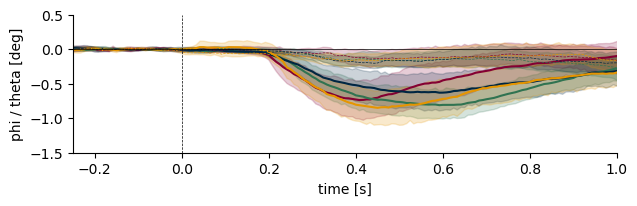

In [6]:
save_to_file = True

df_all["times"] = df_all["times"].round(3)
cm = 1 / 2.54
emotions = cond_dict["emotion"].values()

fig, ax = plt.subplots(figsize=(16.4587 * cm, 5.5 * cm))

df_plt = (df_all
            .copy()
            .groupby(["sub_id", "times", "emotion"],
            as_index=False)
            .agg(phi =  ("phi", "mean"), 
                 theta = ("theta", "mean")))

# flip phi so that negative angles go downwards
df_plt["phi"] = df_plt["phi"].apply(lambda x: x * -1)

sns.lineplot(
    x="times",
    y="phi",
    hue="emotion",
    data=df_plt,
    ax=ax,
    errorbar=("ci", 95),
    palette={emo: colors.COLDICT[emo] for emo in emotions},
)
sns.lineplot(
    x="times",
    y="theta",
    hue="emotion",
    data=df_plt,
    ax=ax,
    errorbar=("ci", 95),
    palette={emo: colors.COLDICT[emo] for emo in emotions},
    linestyle="--",
    linewidth=0.5,
    dashes=(14, 14),
)
ax.set_xlim(-0.25, 1.0)
ax.set_ylim(-1.5, 0.5)
ax.set_ylabel("phi / theta [deg]")
ax.set_xlabel("time [s]")
plt.axvline(0, color="k", linestyle="--", linewidth=0.5)
plt.axhline(0, color="k", linestyle="-", linewidth=0.5)
plt.tight_layout()
# remove right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# dont show the legend
ax.get_legend().remove()
if save_to_file:
    # save as pdf
    fpath = Path(paths.FIGURES, "ET")
    if not fpath.exists():
        fpath.mkdir(parents=True)
    fname = Path(fpath, "ET-phi-theta.pdf")
    matplotlib.rcParams["pdf.fonttype"] = 42
    matplotlib.rcParams["ps.fonttype"] = 42
    matplotlib.rcParams["font.family"] = "Roboto"
    plt.savefig(fname, dpi=300, bbox_inches="tight", transparent=True)

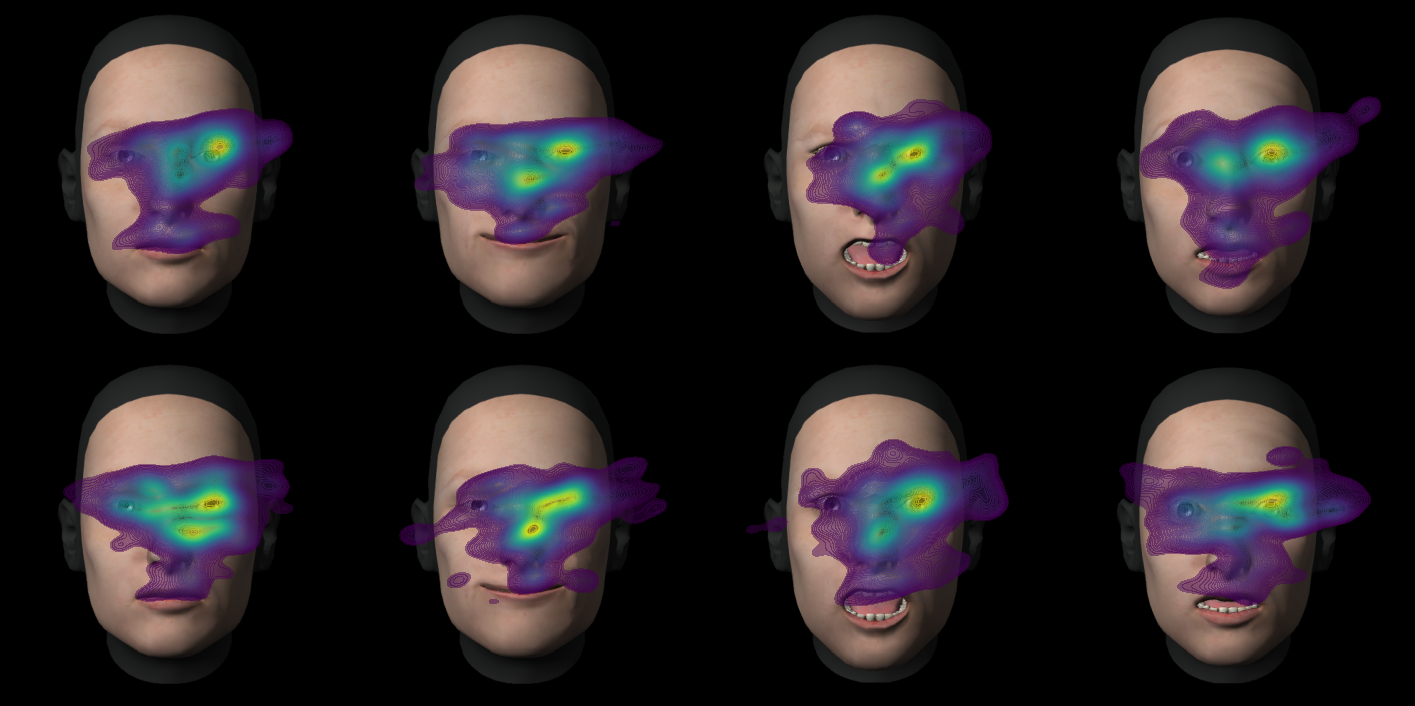

In [7]:
sub_id_plt = "VR2FEM_S03"
img = plt.imread(Path(paths.STIMULIIMAGES, "Woman_08_Angry.png"))
im2 = img[245:-245, 245:-245, :]
height, width, _ = im2.shape

# fig, axs = plt.subplots(3, 4*2, figsize=(12*4/3*2, 12))
fig, axs = plt.subplots(2, 4, figsize=(18, 9))
# set the figure background to black
fig.patch.set_facecolor("black")
fig.patch.set_alpha(1.0)
# set the axes background to black
for ax in axs.flatten():
    ax.patch.set_facecolor("black")
    ax.patch.set_alpha(1.0)
# reduce the space between the subplots
fig.subplots_adjust(hspace=0.02, wspace=0.05)

for vc_idx, viewcond in enumerate(cond_dict["viewcond"].values()):  # noqa: B007
    for av_idx, av_name in enumerate(list(cond_dict["avatar_id"].values())[1:2]):  # noqa: B007
        for emo_idx, emotion in enumerate(cond_dict["emotion"].values()):
            # ax = axs[av_idx, emo_idx + vc_idx*4]
            ax = axs[vc_idx, emo_idx]
            data_plot = (
                df_all.query("times > 0.25 & times < 1")
                .query("emotion == @emotion")
                .query("avatar_id == @av_name")
                .query("viewcond == @viewcond")
                .query(f"sub_id == '{sub_id_plt}'")
            )
            # flip phi so that negative angles go downwards
            data_plot["phi"] = data_plot["phi"].apply(lambda x: x * -1)

            sns.kdeplot(
                data=data_plot,
                x="theta",
                y="phi",
                fill=True,
                cmap="viridis",
                levels=100,
                thresh=0.05,
                alpha=0.45,
                ax=ax,
            )

            img = plt.imread(Path(paths.STIMULIIMAGES, f"{av_name}_{emotion.capitalize()}.png"))
            cutval = 205
            im2 = img[cutval + 35 : -cutval, cutval + 35 : -cutval, :]
            height, width, _ = im2.shape
            # Overlay the image onto the plot, centered on the axes
            ax.imshow(im2, extent=[-5, 5, -5, 5], alpha=1)
            # hide the axes and the ticks and labels
            ax.axis("off")

# save as pdf
fpath = Path(paths.FIGURES, "ET")
if not fpath.exists():
    fpath.mkdir(parents=True)
plt.savefig(Path(fpath, f"Heatmaps_{sub_id_plt}.pdf"), dpi=300, bbox_inches="tight", pad_inches=0)